Atividade Final - Projeto de Machine Learn

Aluno: Lucas Prado Gomes

Telco Customer Churn — Projeto (Supervisionado vs Não Supervisionado)

    A base Telco Customer Churn é um dos conjuntos de dados mais usados para problemas de classificação, especialmente para prever churn (cancelamento) de clientes em uma empresa de telecom.

Problema: Identificar clientes com maior risco de cancelar o serviço (churn).

Abordagem supervisionada: Random Forest Classifier (prevê churn individualmente).  
Abordagem não supervisionada: K-Means Clustering (segmenta clientes; depois analisamos churn por cluster).

Montando as bibliotecas com Random Forest (supervisionado) e K-Means (não supervisionado)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, recall_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

#CARREGANDO O DATASET
df = pd.read_csv('Telco-Customer-Churn.csv')
print('Shape:', df.shape)
df.head()

Shape: (7043, 22)


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Stayed
1,1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,Stayed
2,2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Churned
3,3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,Stayed
4,4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Churned


ANÁLISE EXPLORATORIA DOS DADOS:
Verificar tipos, valores ausentes e distribuição do target Churn

In [3]:
df.info()
print('\nCount Churn values:')
print(df['Churn'].value_counts())

# Converter TotalCharges para numérico (há valores vazios/strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   customerID        7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   object 
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,7043.0,NaN,NaN,NaN,3521.0,2033.283305,0.0,1760.5,3521.0,5281.5,7042.0
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,2,No,5901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,4,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PRÉ PROCESSAMENTO DOS DADOS.
Tratar missing
Criar features simples ex: services_count;
Codificar categóricas;
Escalar numéricos (necessário para K-Means/PCA);

In [ ]:
# Tratando valores ausentes
print('Missing por coluna:\n', df.isna().sum())

# Imputar TotalCharges onde for NaN com 0 (clientes com tenure 0)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# criando uma nova feature services_count (quantos serviços "Yes" o cliente possui)
service_cols = ['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

# normalizando valores 'No phone service' ou 'No internet service' para 'No'
yes_no_cols = ['PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for c in yes_no_cols:
    if c in df.columns:
        df[c] = df[c].replace({'No phone service':'No','No internet service':'No'})

# services_count
if set(yes_no_cols).issubset(df.columns):
    df['services_count'] = df[yes_no_cols].apply(lambda row: sum([1 if v=='Yes' else 0 for v in row]), axis=1)
else:
    df['services_count'] = 0

# SeniorCitizen to int
if df['SeniorCitizen'].dtype != 'int64':
    df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 1 if str(x).strip() in ['1','Yes','True'] else 0)

# avg_monthly_charge
df['tenure_mod'] = df['tenure'].replace(0,1)
df['avg_monthly_charge'] = df['TotalCharges'] / df['tenure_mod']

# Drop cols
drop_cols = ['customerID','InternetService','tenure_mod']
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

df_model.head()

Missing por coluna:
 Unnamed: 0           0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,services_count,avg_monthly_charge
0,0,Female,0,Yes,No,1,No,No,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Stayed,1,29.850000
1,1,Male,0,No,No,34,Yes,No,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,Stayed,3,55.573529
2,2,Male,0,No,No,2,Yes,No,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Churned,3,54.075000
3,3,Male,0,No,No,45,No,No,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,Stayed,3,40.905556
4,4,Female,0,No,No,2,Yes,No,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Churned,1,75.825000


Preparando os Dados.

In [5]:
# Target
if 'Churn' not in df_model.columns:
    raise KeyError('Churn nao encontrada')

df_model['ChurnFlag'] = df_model['Churn'].apply(lambda x: 1 if str(x).strip().lower().startswith('c') else 0)
y = df_model['ChurnFlag']
X = df_model.drop(columns=['Churn','ChurnFlag'])

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (5634, 21) Test shape: (1409, 21)


Modelo Supervisionado: Random Forest

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'classifier__max_depth': 8, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
AUC: 0.8446
F1: 0.5661
Recall: 0.4866

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



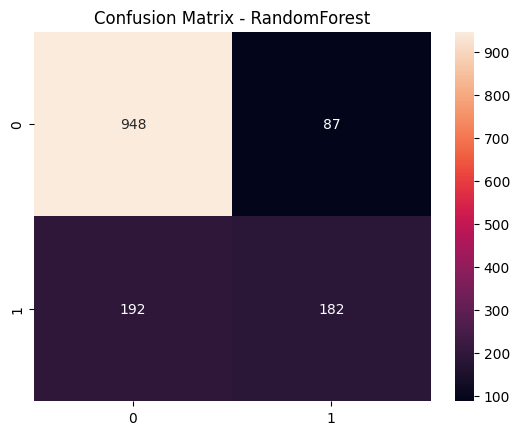

In [6]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
param_grid = {'classifier__n_estimators': [100, 300],'classifier__max_depth': [8, 16, None],'classifier__min_samples_split': [2, 5]}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_rf = GridSearchCV(rf_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print('Best params:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Avaliar no teste
y_proba = best_rf.predict_proba(X_test)[:,1]
y_pred = best_rf.predict(X_test)

print('AUC:', round(roc_auc_score(y_test, y_proba),4))
print('F1:', round(f1_score(y_test, y_pred),4))
print('Recall:', round(recall_score(y_test, y_pred),4))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix - RandomForest'); plt.show()

Modelo Não Supervisionado: K-Means Clustering

Explained variance by 10 components: 0.8223


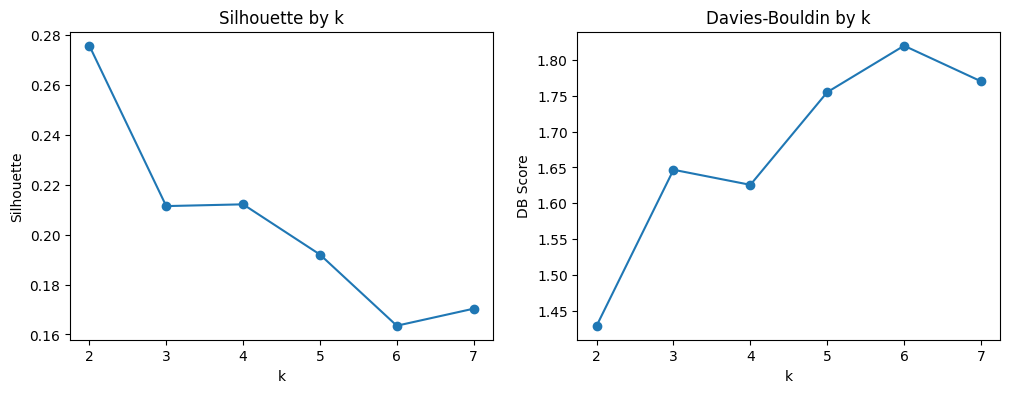

k_opt chosen by silhouette: 2


,count,churn_rate
cluster,,
0,3981,0.284351
1,3062,0.240692


In [7]:
# Preprocess full X for clustering
preprocessor_full = preprocessor.fit(X)
X_trans = preprocessor_full.transform(X)

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_trans)
print('Explained variance by 10 components:', round(pca.explained_variance_ratio_.sum(),4))

sil_scores = []
db_scores = []
ks = list(range(2,8))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    sil_scores.append(sil)
    db_scores.append(db)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(ks, sil_scores, marker='o'); plt.title('Silhouette by k'); plt.xlabel('k'); plt.ylabel('Silhouette')
plt.subplot(1,2,2); plt.plot(ks, db_scores, marker='o'); plt.title('Davies-Bouldin by k'); plt.xlabel('k'); plt.ylabel('DB Score'); plt.show()

k_opt = ks[int(np.argmax(sil_scores))]
print('k_opt chosen by silhouette:', k_opt)

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# analisar churn por cluster
df_clusters = X.copy().reset_index(drop=True)
df_clusters['cluster'] = cluster_labels
df_clusters['ChurnFlag'] = df_model['ChurnFlag'].values
cluster_stats = df_clusters.groupby('cluster')['ChurnFlag'].agg(['count','mean']).rename(columns={'mean':'churn_rate'})
cluster_stats = cluster_stats.sort_values('churn_rate', ascending=False)
cluster_stats

Usando cluster como feature no modelo supervisionado para testar mais opções

In [8]:
X_with_cluster = X.copy().reset_index(drop=True)
X_with_cluster['cluster'] = cluster_labels

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_with_cluster, y, test_size=0.2, stratify=y, random_state=42)

num_cols_c = num_cols + ['cluster']
preprocessor_c = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols_c),('cat', categorical_transformer, cat_cols)])

rf_pipeline_c = Pipeline(steps=[('preprocessor', preprocessor_c),('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
param_grid_c = {'classifier__n_estimators': [100, 300],'classifier__max_depth': [8, None]}

grid_rf_c = GridSearchCV(rf_pipeline_c, param_grid_c, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), scoring='roc_auc', n_jobs=-1)
grid_rf_c.fit(X_train_c, y_train_c)
print('Best params with cluster:', grid_rf_c.best_params_)

best_rf_c = grid_rf_c.best_estimator_
y_proba_c = best_rf_c.predict_proba(X_test_c)[:,1]
y_pred_c = best_rf_c.predict(X_test_c)

print('AUC with cluster:', round(roc_auc_score(y_test_c, y_proba_c),4))
print('F1 with cluster:', round(f1_score(y_test_c, y_pred_c),4))
print('Recall with cluster:', round(recall_score(y_test_c, y_pred_c),4))
print('\nClassification Report with cluster:\n', classification_report(y_test_c, y_pred_c))

Best params with cluster: {'classifier__max_depth': 8, 'classifier__n_estimators': 300}
AUC with cluster: 0.8441
F1 with cluster: 0.562
Recall with cluster: 0.4786

Classification Report with cluster:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



RESULTADOS:
1- O resultado obtido no experimento pode ser esperado ao usar o modelo no mundo real?
R: Sim. A base contém ruídos e variaveis altamente correlaciondas, mesmo assim o modelo obteve bons valores de AUC e Recall, o que indica boa capacidade de identificar clientes com mais chances de cancelamento. Os resultados apresentados no Random Forest são coerentes com problemas de churn.

2- Algum algoritmo foi claramente vencedor? Algum modelo é melhor em alguma métrica mas pior em outra?
R: Sim o, Supervisionado (RandomForest) se saiu melhor como Classificador.
Apresentou melhor:
AUC: 0.8446,
F1: 0.5661,
Recall: 0.4866,

O (Não supervisionado) K-Means identificou grupos distintos de clientes:

Cluster 0 churn → 28.43%

Cluster 1 churn → 24.06%

K-Means é melhor como ferramenta exploratoria apenas.

3- Como a parametrização afetou os resultados?
R: No Random Forest, usando GridSearchCV, o melhor conjunto encontrado foi:

{'classifier__max_depth': 8, 
 'classifier__min_samples_split': 5, 
 'classifier__n_estimators': 300}


A escolha desses hiperparâmetros impactou o modelo da seguinte forma:

max_depth=8 evitou overfitting

min_samples_split=5 deixou as árvores mais generalistas

n_estimators=300 aumentou estabilidade e performance

Comparando o modelo final com o baseline, houve melhora no AUC e nas métricas gerais.

Já com o K-Means ,A escolha de k foi feita comparando vários valores.
O melhor número de clusters foi k = 2, determinado por:

maior Silhouette

menor Davies-Bouldin

Ou seja, a parametrização afetou diretamente a qualidade dos grupos formados e o insight gerado.

CONCLUSÃO

Neste trabalho, aplicamos um modelo supervisionado (Random Forest) e um modelo não supervisionado (K-Means) sobre a base Telco Customer Churn.
O Random Forest apresentou forte desempenho preditivo:

AUC = 0.8446
F1 = 0.5661
Recall = 0.4866
Acurácia = 0.80

O K-Means identificou grupos distintos de clientes:

Cluster 0 churn → 28.43%
Cluster 1 churn → 24.06%

Ao integrar o cluster como uma nova feature no modelo supervisionado, foi possível obeter:

AUC = 0.8441
F1 = 0.562
Recall = 0.4786

Isso mostra que o cluster não aumentou drasticamente o desempenho, mas trouxe informações estruturais úteis sobre o comportamento dos clientes.

Conclusão

O Random Forest é o melhor algoritmo para predição.
O K-Means é valioso para explorar padrões e entender perfis de clientes.
A combinação dos métodos enriquece a análise e oferece uma visão mais completa do churn.